### Flatten the output of the imu json file

In [ ]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from scipy.signal import butter, filtfilt



IMU_SAMPLE_RATE = 52
DT = 1.0 / IMU_SAMPLE_RATE

# Physical sensor limits (from IMU specifications)
SENSOR_LIMITS = {
    # Accelerometer: ±16 g = ±156.96 m/s²
    # Typical Movesense IMU range
    'ax': (-156.96, 156.96),  # m/s²
    'ay': (-156.96, 156.96),
    'az': (-156.96, 156.96),

    # Gyroscope: ±1000°/s (Movesense default)
    'gx': (-1000, 1000),      # °/s
    'gy': (-1000, 1000),
    'gz': (-1000, 1000),
}

def flatten_movesense_imu_repeat(raw_json, fatigue_level, remove_outliers=True):
    """
    Flatten IMU JSON packets into rows and attach the given fatigue level.
    Now with outlier detection and removal based on sensor limits.
    """
    rows = []
    skipped_packets = 0
    repeated_rows_count = 0

    # Outlier counters
    acc_outliers = 0
    gyro_outliers = 0
    total_rows_processed = 0

    packets = raw_json.get("data", [])
    first_packet_timestamp_s = None

    for packet in packets:
        imu = packet.get("imu")
        if not imu:
            skipped_packets += 1
            continue

        timestamp_ms = imu.get("Timestamp")
        acc_list = imu.get("ArrayAcc", [])
        gyro_list = imu.get("ArrayGyro", [])

        if timestamp_ms is None or not acc_list or not gyro_list:
            skipped_packets += 1
            continue

        packet_timestamp_s = timestamp_ms / 1000.0

        if first_packet_timestamp_s is None:
            first_packet_timestamp_s = packet_timestamp_s

        packet_timestamp_s -= first_packet_timestamp_s

        len_acc = len(acc_list)
        len_gyro = len(gyro_list)
        n_samples = max(len_acc, len_gyro)

        last_row = None

        for i in range(n_samples):
            total_rows_processed += 1

            # Gyro
            if i < len_gyro:
                g = gyro_list[i]
                gx = float(g.get("x", 0.0))
                gy = float(g.get("y", 0.0))
                gz = float(g.get("z", 0.0))
            else:
                gx, gy, gz = last_row["gx"], last_row["gy"], last_row["gz"]

            # Acc
            if i < len_acc:
                a = acc_list[i]
                ax = float(a.get("x", 0.0))
                ay = float(a.get("y", 0.0))
                az = float(a.get("z", 0.0))
            else:
                ax, ay, az = last_row["ax"], last_row["ay"], last_row["az"]

            # Check for sensor limit outliers
            is_outlier = False

            # 1. Check individual sensor limits
            if ax < SENSOR_LIMITS['ax'][0] or ax > SENSOR_LIMITS['ax'][1]:
                acc_outliers += 1
                is_outlier = True

            if ay < SENSOR_LIMITS['ay'][0] or ay > SENSOR_LIMITS['ay'][1]:
                acc_outliers += 1
                is_outlier = True

            if az < SENSOR_LIMITS['az'][0] or az > SENSOR_LIMITS['az'][1]:
                acc_outliers += 1
                is_outlier = True

            if gx < SENSOR_LIMITS['gx'][0] or gx > SENSOR_LIMITS['gx'][1]:
                gyro_outliers += 1
                is_outlier = True

            if gy < SENSOR_LIMITS['gy'][0] or gy > SENSOR_LIMITS['gy'][1]:
                gyro_outliers += 1
                is_outlier = True

            if gz < SENSOR_LIMITS['gz'][0] or gz > SENSOR_LIMITS['gz'][1]:
                gyro_outliers += 1
                is_outlier = True

            # Skip this row if it's an outlier and we're removing outliers
            if is_outlier and remove_outliers:
                continue

            sample_timestamp = packet_timestamp_s + i * DT

            current_row = {
                "timestamp_s": round(sample_timestamp, 6),
                "gx": gx,
                "gy": gy,
                "gz": gz,
                "ax": ax,
                "ay": ay,
                "az": az,
                "fatigue_level": fatigue_level
            }

            rows.append(current_row)
            last_row = current_row

            if i >= len_acc or i >= len_gyro:
                repeated_rows_count += 1

    # Calculate statistics
    total_outliers = acc_outliers + gyro_outliers

    return rows, skipped_packets, repeated_rows_count, {
        'total_rows_processed': total_rows_processed,
        'total_outliers': total_outliers,
        'acc_outliers': acc_outliers,
        'gyro_outliers': gyro_outliers,
        'outlier_percentage': (total_outliers / total_rows_processed * 100) if total_rows_processed > 0 else 0
    }


def process_json(input_json_path, output_csv_path, fatigue_level, remove_outliers=True):
    """
    Process a raw IMU JSON file and export a flattened CSV with fatigue level.
    Now includes outlier detection and optional removal.
    """
    with open(input_json_path, "r") as f:
        raw_json = json.load(f)

    flattened_rows, skipped_packets, repeated_rows_count, outlier_stats = \
        flatten_movesense_imu_repeat(raw_json, fatigue_level, remove_outliers)

    print(f"\n{'='*60}")
    print(f"Processing: {input_json_path} (Fatigue Level: {fatigue_level})")
    print(f"{'='*60}")

    print(f"• Skipped packets: {skipped_packets}")
    print(f"• Repeated rows (unequal arrays): {repeated_rows_count}")
    print(f"• Total rows processed: {outlier_stats['total_rows_processed']}")
    print(f"• Rows saved to CSV: {len(flattened_rows)}")

    print(f"\nOutlier Detection Results:")
    print(f"• Total outliers detected: {outlier_stats['total_outliers']}")
    print(f"• Outlier percentage: {outlier_stats['outlier_percentage']:.2f}%")
    print(f"• Accelerometer outliers: {outlier_stats['acc_outliers']}")
    print(f"• Gyroscope outliers: {outlier_stats['gyro_outliers']}")

    if remove_outliers:
        print(f"• Outliers removed: {outlier_stats['total_outliers']}")
        print(f"• Clean rows remaining: {len(flattened_rows)}")
    else:
        print(f"• Outliers flagged but not removed")

    # Save to CSV - WITHOUT is_outlier and outlier_reasons columns
    with open(output_csv_path, "w", newline="") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=["timestamp_s", "gx", "gy", "gz", "ax", "ay", "az", "fatigue_level"]
        )
        writer.writeheader()
        writer.writerows(flattened_rows)

    print(f"\n✓ Saved clean CSV: {output_csv_path}")

    return outlier_stats


def analyze_sensor_statistics(input_json_path, fatigue_level):
    """
    Analyze sensor statistics without saving CSV
    """
    with open(input_json_path, "r") as f:
        raw_json = json.load(f)

    # Process without removing outliers to analyze them
    rows, _, _, stats = flatten_movesense_imu_repeat(raw_json, fatigue_level, remove_outliers=False)

    # Calculate additional statistics
    if rows:
        # Extract sensor values
        ax_vals = [row['ax'] for row in rows]
        ay_vals = [row['ay'] for row in rows]
        az_vals = [row['az'] for row in rows]
        gx_vals = [row['gx'] for row in rows]
        gy_vals = [row['gy'] for row in rows]
        gz_vals = [row['gz'] for row in rows]

        print(f"\n{'='*60}")
        print(f"Sensor Statistics: {input_json_path}")
        print(f"{'='*60}")

        print(f"\nAccelerometer (m/s²):")
        print(f"  ax: min={min(ax_vals):.2f}, max={max(ax_vals):.2f}, mean={np.mean(ax_vals):.2f}")
        print(f"  ay: min={min(ay_vals):.2f}, max={max(ay_vals):.2f}, mean={np.mean(ay_vals):.2f}")
        print(f"  az: min={min(az_vals):.2f}, max={max(az_vals):.2f}, mean={np.mean(az_vals):.2f}")

        print(f"\nGyroscope (°/s):")
        print(f"  gx: min={min(gx_vals):.2f}, max={max(gx_vals):.2f}, mean={np.mean(gx_vals):.2f}")
        print(f"  gy: min={min(gy_vals):.2f}, max={max(gy_vals):.2f}, mean={np.mean(gy_vals):.2f}")
        print(f"  gz: min={min(gz_vals):.2f}, max={max(gz_vals):.2f}, mean={np.mean(gz_vals):.2f}")

        # Check for sensor saturation
        print(f"\nSensor Saturation Check:")
        for sensor, values, limit in [('ax', ax_vals, 156.96), ('ay', ay_vals, 156.96), ('az', az_vals, 156.96),
        ('gx', gx_vals, 1000), ('gy', gy_vals, 1000), ('gz', gz_vals, 1000)]:
            near_limit = sum(1 for v in values if abs(v) > limit * 0.95)  # Within 5% of limit
            if near_limit > 0:
                print(f"  {sensor}: {near_limit} values near saturation ({near_limit/len(values)*100:.1f}%)")

    return stats

# Process all files with outlier removal
print("="*70)
print("IMU DATA PROCESSING WITH OUTLIER DETECTION AND REMOVAL")
print("="*70)

total_stats = {
    'total_rows_processed': 0,
    'total_outliers': 0,
    'acc_outliers': 0,
    'gyro_outliers': 0,
}

# First, analyze statistics
print("\n" + "="*70)
print("ANALYZING SENSOR STATISTICS (Outliers flagged but not removed)")
print("="*70)

files_to_process = [
    #("imu1.json", "flattened_imu_output1.csv", -1),
    ("imu_level0.json", "flattened_imu_output_level0.csv", 0),
    ("imu_level1.json", "flattened_imu_output_level1.csv", 1),
    ("imu_level2.json", "flattened_imu_output_level2.csv", 2),
    ("imu_level3.json", "flattened_imu_output_level3.csv", 3)

]

for input_file, output_file, fatigue_level in files_to_process:
    try:
        print(f"\nAnalyzing {input_file}...")
        stats = analyze_sensor_statistics(input_file, fatigue_level)

        # Accumulate statistics
        for key in total_stats.keys():
            total_stats[key] += stats[key]

    except FileNotFoundError:
        print(f"  File not found: {input_file}")
    except Exception as e:
        print(f"  Error analyzing {input_file}: {e}")

# Now process with outlier removal
print("\n" + "="*70)
print("PROCESSING WITH OUTLIER REMOVAL")
print("="*70)

all_processing_stats = []

for input_file, output_file, fatigue_level in files_to_process:
    try:
        stats = process_json(input_file, output_file, fatigue_level, remove_outliers=True)
        all_processing_stats.append({
            'file': input_file,
            'level': fatigue_level,
            'stats': stats
        })
    except FileNotFoundError:
        print(f"\nFile not found: {input_file}")
    except Exception as e:
        print(f"\nError processing {input_file}: {e}")

# Print comprehensive summary
print("\n" + "="*70)
print("COMPREHENSIVE OUTLIER SUMMARY")
print("="*70)

print(f"\n{'File':<30} {'Level':<8} {'Total Rows':<12} {'Outliers':<12} {'% Outliers':<12}")
print("-" * 90)

for item in all_processing_stats:
    stats = item['stats']
    print(f"{item['file']:<30} {item['level']:<8} {stats['total_rows_processed']:<12} "
          f"{stats['total_outliers']:<12} {stats['outlier_percentage']:<12.2f}")

print("-" * 90)

if total_stats['total_rows_processed'] > 0:
    overall_outlier_pct = (total_stats['total_outliers'] / total_stats['total_rows_processed']) * 100

    print(f"\nOVERALL TOTALS:")
    print(f"• Total rows processed: {total_stats['total_rows_processed']}")
    print(f"• Total outliers detected: {total_stats['total_outliers']}")
    print(f"• Overall outlier percentage: {overall_outlier_pct:.2f}%")
    print(f"\nBreakdown by type:")
    print(f"  • Accelerometer outliers: {total_stats['acc_outliers']}")
    print(f"  • Gyroscope outliers: {total_stats['gyro_outliers']}")

    # Recommendations
    print(f"\nRECOMMENDATIONS:")
    if overall_outlier_pct > 10:
        print("⚠️  High outlier rate (>10%). Consider:")
        print("   • Checking sensor placement and calibration")
        print("   • Reviewing data collection environment")
        print("   • Applying additional filtering in preprocessing")
    elif overall_outlier_pct > 5:
        print("⚠️  Moderate outlier rate (5-10%). Standard filtering applied.")
    else:
        print("✓ Good data quality (<5% outliers).")

# Create a summary CSV file
summary_csv = "imu_processing_summary.csv"
with open(summary_csv, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=[
        'file', 'fatigue_level', 'total_rows', 'outliers_detected',
        'outlier_percentage', 'acc_outliers', 'gyro_outliers',
    ])
    writer.writeheader()

    for item in all_processing_stats:
        stats = item['stats']
        writer.writerow({
            'file': item['file'],
            'fatigue_level': item['level'],
            'total_rows': stats['total_rows_processed'],
            'outliers_detected': stats['total_outliers'],
            'outlier_percentage': stats['outlier_percentage'],
            'acc_outliers': stats['acc_outliers'],
            'gyro_outliers': stats['gyro_outliers'],
        })

print(f"\n✓ Processing summary saved to: {summary_csv}")
print("\n" + "="*70)
print("PROCESSING COMPLETE!")
print("="*70)

IMU DATA PROCESSING WITH OUTLIER DETECTION AND REMOVAL

ANALYZING SENSOR STATISTICS (Outliers flagged but not removed)

Analyzing imu_level0.json...

Sensor Statistics: imu_level0.json

Accelerometer (m/s²):
  ax: min=1.75, max=6.77, mean=5.29
  ay: min=-10.35, max=-7.60, mean=-8.39
  az: min=-2.74, max=1.56, mean=-0.27

Gyroscope (°/s):
  gx: min=-33.11, max=24.57, mean=1.12
  gy: min=-29.05, max=29.68, mean=-2.09
  gz: min=-26.74, max=38.15, mean=-0.93

Sensor Saturation Check:

Analyzing imu_level1.json...

Sensor Statistics: imu_level1.json

Accelerometer (m/s²):
  ax: min=-28.82, max=23.96, mean=1.07
  ay: min=-52.53, max=5.10, mean=-9.84
  az: min=-15.36, max=9.35, mean=0.30

Gyroscope (°/s):
  gx: min=-238.35, max=109.41, mean=0.39
  gy: min=-206.29, max=215.60, mean=-2.69
  gz: min=-116.48, max=62.93, mean=-1.46

Sensor Saturation Check:

Analyzing imu_level2.json...

Sensor Statistics: imu_level2.json

Accelerometer (m/s²):
  ax: min=-28.87, max=30.74, mean=-1.84
  ay: min=-17

### Adding low pass filtering for imu data

Saved filtered CSV to flattened_imu_output_level0_filtered.csv


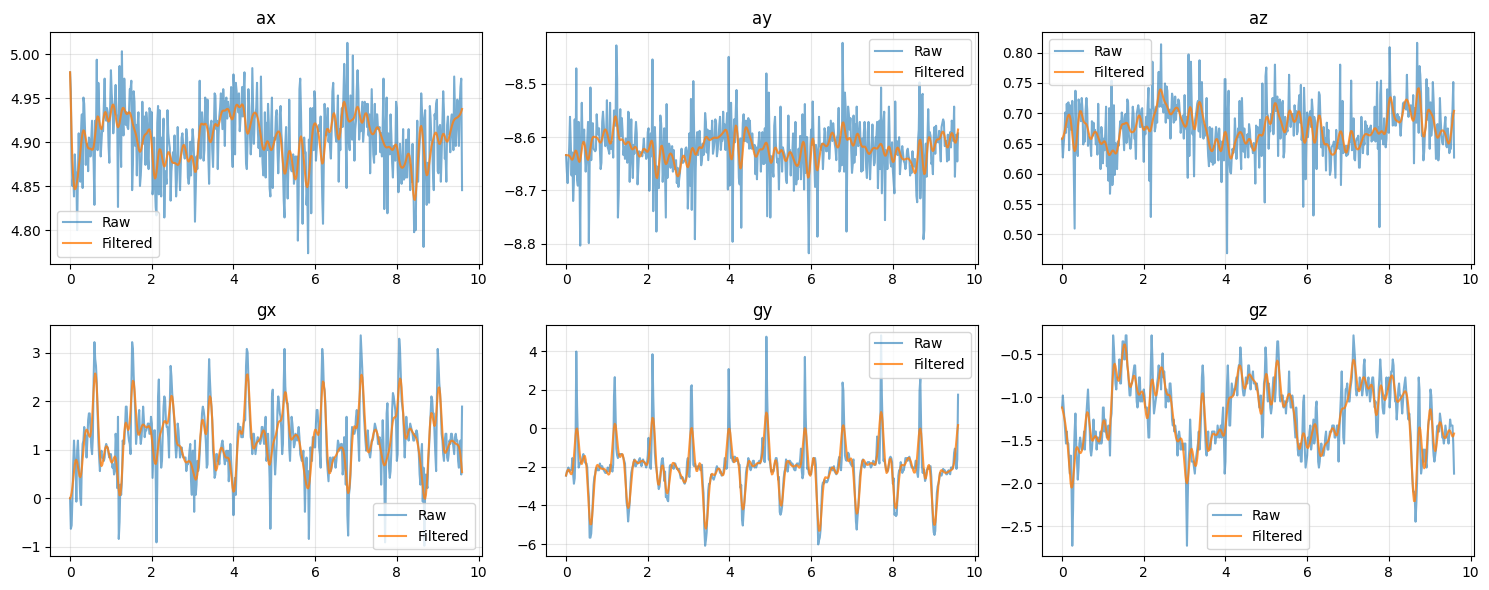

Saved filtered CSV to flattened_imu_output_level1_filtered.csv


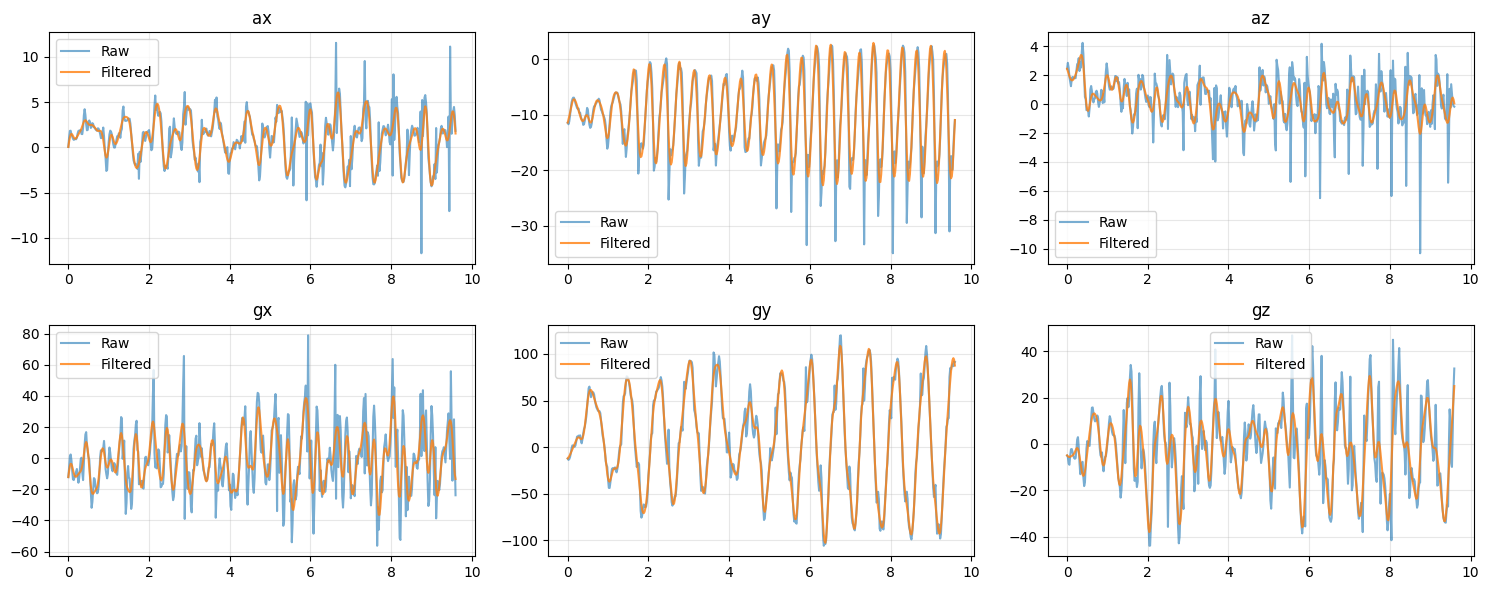

Saved filtered CSV to flattened_imu_output_level2_filtered.csv


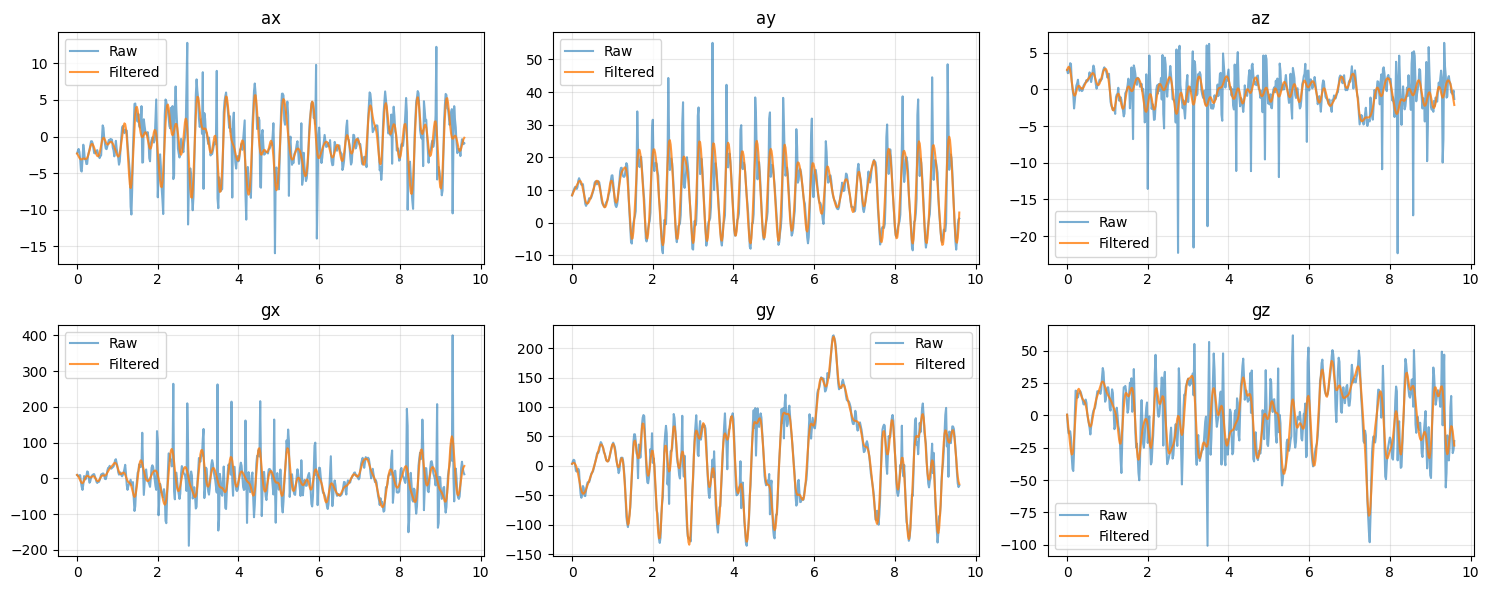

Saved filtered CSV to flattened_imu_output_level3_filtered.csv


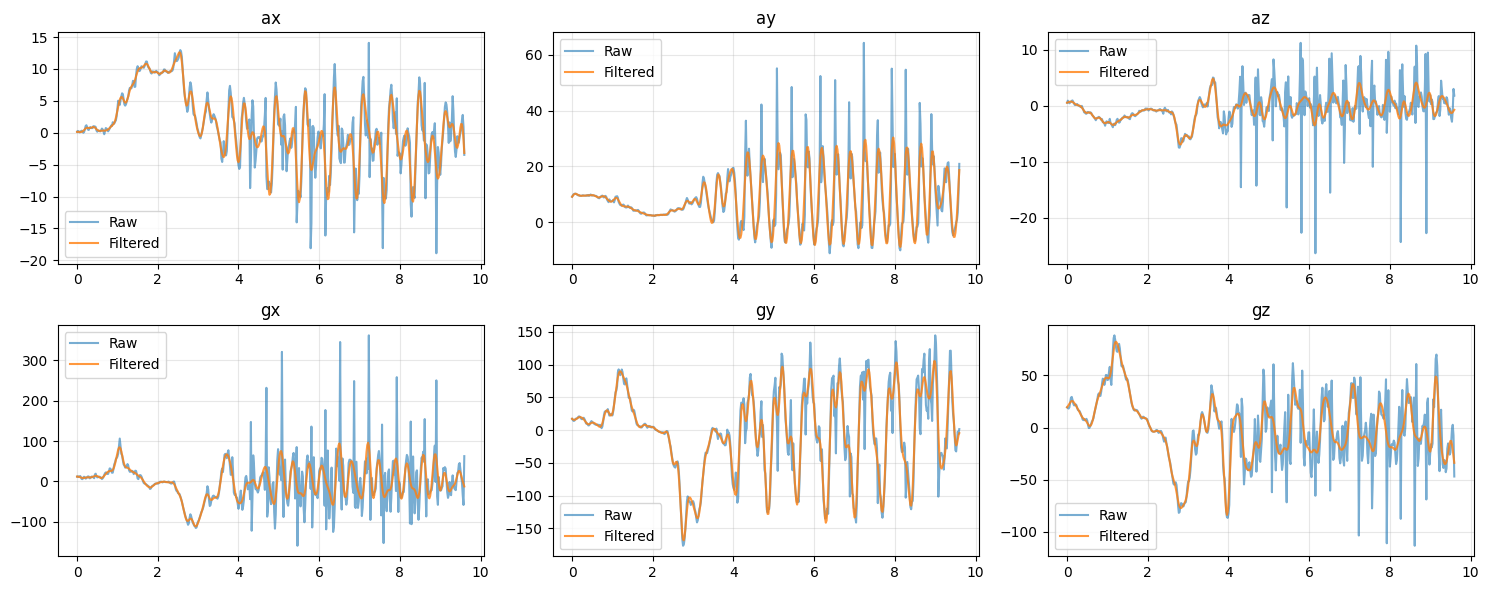

In [ ]:

def low_pass_filter_imu(input_csv, output_csv, cutoff_hz=5, fs=52, order=4, plot_samples=500):
    """
    Apply a low-pass Butterworth filter to IMU data and overwrite original ax, ay, az, gx, gy, gz.
    Also visualize before and after filtering.

    Parameters:
        input_csv (str): path to input CSV
        output_csv (str): path to save filtered CSV
        cutoff_hz (float): cutoff frequency in Hz
        fs (float): sampling frequency in Hz
        order (int): filter order
        plot_samples (int): number of samples to plot for visualization
    """
    # Read CSV
    df = pd.read_csv(input_csv)

    imu_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    for col in imu_cols:
        if col not in df.columns:
            raise ValueError(f"Input CSV must contain column '{col}'")

    # Design low-pass Butterworth filter
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_hz / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Store filtered data
    df_filtered = df.copy()
    for col in imu_cols:
        df_filtered[col] = filtfilt(b, a, df[col].values)

    # Save filtered CSV
    df_filtered.to_csv(output_csv, index=False)
    print(f"Saved filtered CSV to {output_csv}")

    # Visualize first plot_samples for comparison
    time = np.arange(len(df)) / fs
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()
    for i, col in enumerate(imu_cols):
        axes[i].plot(time[:plot_samples], df[col].values[:plot_samples], label='Raw', alpha=0.6)
        axes[i].plot(time[:plot_samples], df_filtered[col].values[:plot_samples], label='Filtered', alpha=0.8)
        axes[i].set_title(col)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
for i in range(4):
    input_file = f"flattened_imu_output_level{i}.csv"
    output_file = f"flattened_imu_output_level{i}_filtered.csv"
    low_pass_filter_imu(input_file, output_file)


### Checking the performance of filtering


=== Filtering Report for flattened_imu_output_level0.csv ===
ax: variance reduction = 0.0025 (2.39%)


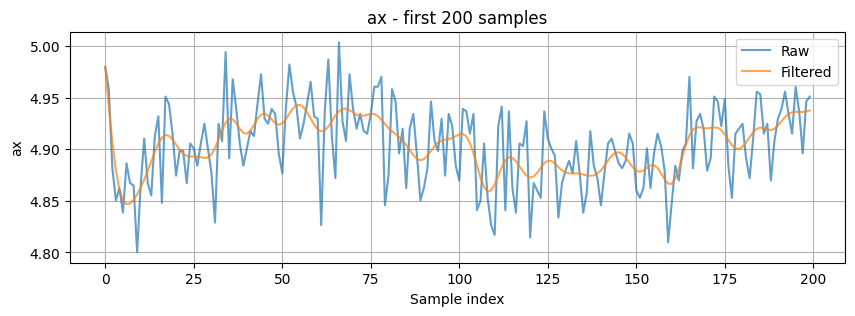

ay: variance reduction = 0.0038 (9.46%)


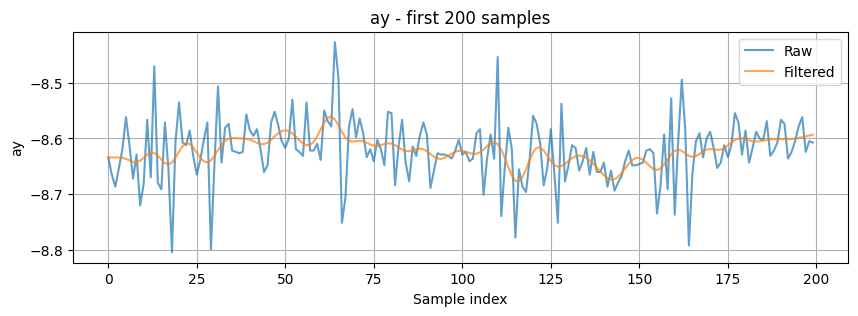

az: variance reduction = 0.0022 (1.19%)


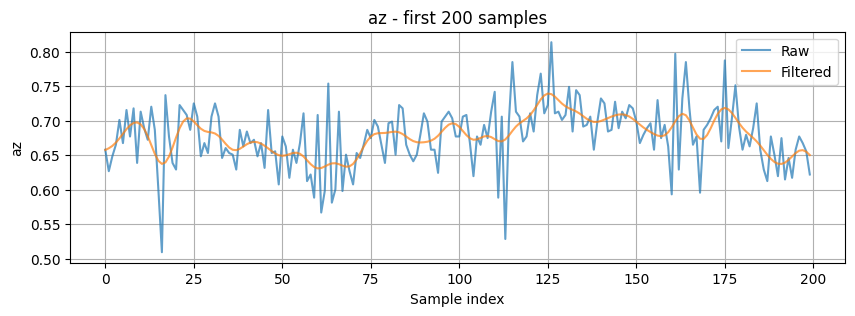

gx: variance reduction = 0.3440 (14.72%)


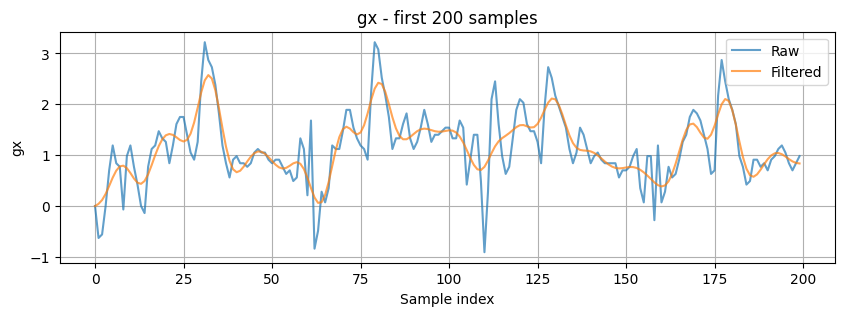

gy: variance reduction = 0.8188 (16.33%)


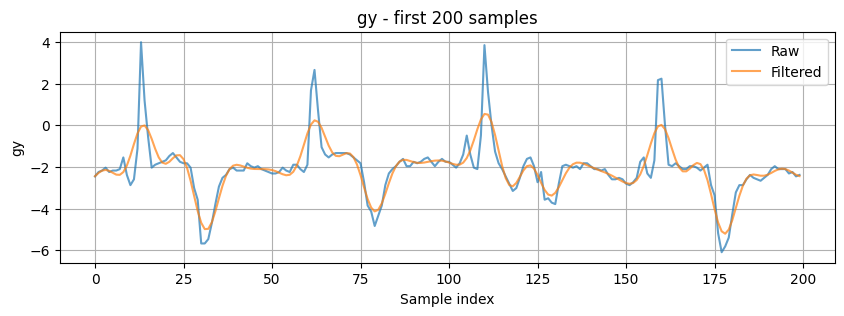

gz: variance reduction = 0.1007 (4.82%)


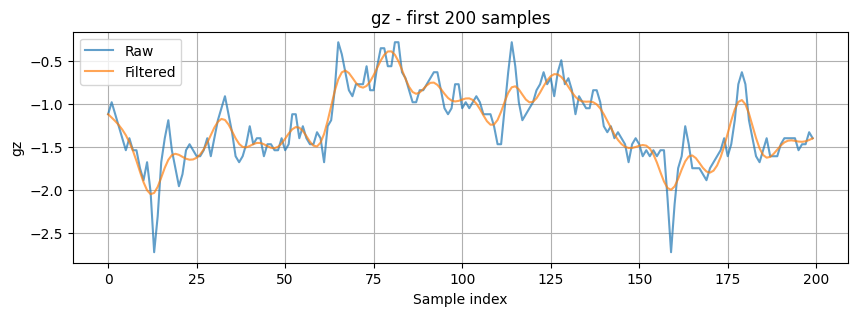

=== Filtering completed ===



In [ ]:


def lowpass_filter_check(input_csv, cutoff=5, fs=52, order=4):
    """
    Apply low-pass filter to all IMU channels and check effectiveness.

    Parameters:
        input_csv (str): Path to input CSV (must contain ax, ay, az, gx, gy, gz)
        cutoff (float): Cutoff frequency in Hz
        fs (float): Sampling frequency in Hz
        order (int): Order of Butterworth filter

    Returns:
        df_filtered (DataFrame): filtered data (overwrites original columns)
    """
    # Load CSV
    df = pd.read_csv(input_csv, sep=None, engine='python')

    imu_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

    for col in imu_cols:
        if col not in df.columns:
            raise ValueError(f"CSV must contain column '{col}'")

    # Design low-pass filter
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    df_filtered = df.copy()

    print(f"\n=== Filtering Report for {input_csv} ===")
    for col in imu_cols:
        # Apply filter and overwrite original column
        df_filtered[col] = filtfilt(b, a, df[col])

        # Variance before and after
        var_raw = df[col].var()
        var_filt = df_filtered[col].var()
        reduction = var_raw - var_filt
        print(f"{col}: variance reduction = {reduction:.4f} ({100*reduction/var_raw:.2f}%)")

        # Plot a small segment for visualization
        plt.figure(figsize=(10,3))
        plt.plot(df[col].iloc[:200], label='Raw', alpha=0.7)
        plt.plot(df_filtered[col].iloc[:200], label='Filtered', alpha=0.7)
        plt.title(f"{col} - first 200 samples")
        plt.xlabel('Sample index')
        plt.ylabel(col)
        plt.legend()
        plt.grid(True)
        plt.show()

    print("=== Filtering completed ===\n")
    return df_filtered

# Example usage:
df_filt = lowpass_filter_check("flattened_imu_output_level0.csv")
# Save filtered data if needed
df_filt.to_csv("imu_filtered_level0.csv", index=False)


### Adding the Acc Mag feature and Gyro Mag feature





In [ ]:
def add_acceleration_gyro_magnitude(input_csv, output_csv):
    """
    Reads a CSV with columns ax, ay, az (IMU accelerometer),
    computes acceleration magnitude for each row, and saves a new CSV.

    Parameters:
        input_csv (str): path to input CSV
        output_csv (str): path to save output CSV
    """
    # Read CSV
    df = pd.read_csv(input_csv, sep=None, engine='python')  # auto-detect separator

    # Check columns
    required_cols_acc = ['ax', 'ay', 'az']
    required_cols_gyro = ['gx', 'gy', 'gz']
    for col in required_cols_acc:
        if col not in df.columns:
            raise ValueError(f"Input CSV must contain column '{col}'")

    # Compute acceleration magnitude
    df['acc_mag'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
    for col in required_cols_gyro:
        if col not in df.columns:
            raise ValueError(f"Input CSV must contain column '{col}'")
    df['gyro_mag'] = np.sqrt(df['gx']**2 + df['gy']**2 + df['gz']**2)

    # Save new CSV
    df.to_csv(output_csv, index=False)
    print(f"Saved new CSV with acceleration magnitude and gyro magnitude to {output_csv}")

# Example usage
add_acceleration_gyro_magnitude("flattened_imu_output_level0.csv", "imu_with_acc_mag_level0.csv")
add_acceleration_gyro_magnitude("flattened_imu_output_level1.csv", "imu_with_acc_mag_level1.csv")
add_acceleration_gyro_magnitude("flattened_imu_output_level2.csv", "imu_with_acc_mag_level2.csv")
add_acceleration_gyro_magnitude("flattened_imu_output_level3.csv", "imu_with_acc_mag_level3.csv")
#add_acceleration_gyro_magnitude("flattened_imu_output1.csv", "imu_with_acc_mag1.csv")

Saved new CSV with acceleration magnitude and gyro magnitude to imu_with_acc_mag_level0.csv
Saved new CSV with acceleration magnitude and gyro magnitude to imu_with_acc_mag_level1.csv
Saved new CSV with acceleration magnitude and gyro magnitude to imu_with_acc_mag_level2.csv
Saved new CSV with acceleration magnitude and gyro magnitude to imu_with_acc_mag_level3.csv


### Flattening the heart rate json

In [ ]:
import json
import csv

def process_heart_rate_json_multiple_rr_seconds(input_json_file, output_csv_file):
    """
    Converts Movesense heart rate JSON into a CSV with:
    timestamp_s, average, rr_s

    - Each RR in rrData array becomes a separate line.
    - Timestamp is cumulative sum of RR intervals (in seconds).
    - RR is also converted to seconds.
    - If HR is missing but RR present, use last HR value.
    - If RR is missing but HR present, repeat last RR interval for timestamp increment.
    - If both are missing, discard.
    - Filters outliers based on specs:
        Heart rate: 20-240 BPM
        R-R intervals: 200-2000ms (0.2-2.0s)
    """
    with open(input_json_file, "r") as f:
        raw_data = json.load(f)

    rows = []
    cumulative_rr_ms = 0
    last_hr_avg = None
    last_rr_ms = None

    # Counters for statistics
    total_entries = 0
    hr_outliers_removed = 0
    rr_outliers_removed = 0

    for entry in raw_data.get("data", []):
        hr = entry.get("heartRate", {})

        avg = hr.get("average", None)
        rr_array = hr.get("rrData", [])

        # Skip entry if both HR and RR are missing
        if avg is None and not rr_array:
            continue

        # Use last HR if missing
        if avg is None:
            avg = last_hr_avg

        # Filter heart rate outliers (30-200 BPM)
        if avg is not None:
            total_entries += 1
            if avg <30 or avg > 200:
                hr_outliers_removed += 1
                avg = None  # Mark as outlier

        # Filter RR intervals in the array (200-2000ms)
        filtered_rr_array = []
        for rr_ms in rr_array:
            if rr_ms >= 300 and rr_ms <= 2000:
                filtered_rr_array.append(rr_ms)
            else:
                rr_outliers_removed += 1

        # If after filtering, RR array is empty but we had valid RR before
        if not filtered_rr_array and last_rr_ms is not None:
            # Only use last RR if it was valid
            if last_rr_ms >= 300 and last_rr_ms <= 2000:
                filtered_rr_array = [last_rr_ms]
            else:
                # Last RR was also invalid, skip this entry
                continue

        # Skip if both HR and RR are invalid after filtering
        if avg is None and not filtered_rr_array:
            continue

        # Process filtered RR intervals
        for rr_ms in filtered_rr_array:
            cumulative_rr_ms += rr_ms
            row = {
                "timestamp_s": cumulative_rr_ms / 1000.0,
                "average": avg,
                "rr_ms": rr_ms
            }
            rows.append(row)
            last_rr_ms = rr_ms

        last_hr_avg = avg

    # Save to CSV
    with open(output_csv_file, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["timestamp_s", "average", "rr_ms"])
        writer.writeheader()
        writer.writerows(rows)

    print(f"Heart rate CSV saved to: {output_csv_file}")
    print(f"  Total entries processed: {total_entries}")
    print(f"  HR outliers removed (<30 or >200 BPM): {hr_outliers_removed}")
    print(f"  RR outliers removed (<300ms or >2000ms): {rr_outliers_removed}")
    print(f"  Valid entries written: {len(rows)}")

# Run processing
process_heart_rate_json_multiple_rr_seconds("hr_level0.json", "hr_flattened_level0.csv")
process_heart_rate_json_multiple_rr_seconds("hr_level1.json", "hr_flattened_level1.csv")
process_heart_rate_json_multiple_rr_seconds("hr_level2.json", "hr_flattened_level2.csv")
process_heart_rate_json_multiple_rr_seconds("hr_level3.json", "hr_flattened_level3.csv")
#process_heart_rate_json_multiple_rr_seconds("hr1.json", "hr_flattened1.csv")

Heart rate CSV saved to: hr_flattened_level0.csv
  Total entries processed: 923
  HR outliers removed (<30 or >200 BPM): 0
  RR outliers removed (<300ms or >2000ms): 0
  Valid entries written: 923
Heart rate CSV saved to: hr_flattened_level1.csv
  Total entries processed: 1654
  HR outliers removed (<30 or >200 BPM): 0
  RR outliers removed (<300ms or >2000ms): 177
  Valid entries written: 1654
Heart rate CSV saved to: hr_flattened_level2.csv
  Total entries processed: 904
  HR outliers removed (<30 or >200 BPM): 0
  RR outliers removed (<300ms or >2000ms): 49
  Valid entries written: 904
Heart rate CSV saved to: hr_flattened_level3.csv
  Total entries processed: 508
  HR outliers removed (<30 or >200 BPM): 0
  RR outliers removed (<300ms or >2000ms): 29
  Valid entries written: 508


### Estimating the HR rest and HR max

In [ ]:


def estimate_hr_rest(csv_file, hr_column="average"):
    """
    Estimate resting heart rate (HR_rest) from a CSV file.

    Parameters:
        csv_file (str): Path to CSV containing HR data.
        hr_column (str): Name of the HR column. Default is "average".

    Returns:
        float: Estimated HR_rest (mean of HR values, assuming low-activity CSV)
    """
    df = pd.read_csv(csv_file)
    if hr_column not in df.columns:
        raise ValueError(f"Column '{hr_column}' not found in {csv_file}")
    hr_rest = df[hr_column].mean()
    return hr_rest

def estimate_hr_max(csv_file, hr_column="average"):
    """
    Estimate maximum heart rate (HR_max) from a CSV file.

    Parameters:
        csv_file (str): Path to CSV containing HR data.
        hr_column (str): Name of the HR column. Default is "average".

    Returns:
        float: Estimated HR_max (max of HR values, assuming high-activity CSV)
    """
    df = pd.read_csv(csv_file)
    if hr_column not in df.columns:
        raise ValueError(f"Column '{hr_column}' not found in {csv_file}")
    hr_max = df[hr_column].max()
    return hr_max

# Example usage:
hr_rest_est = estimate_hr_rest("hr_flattened_level0.csv")
hr_max_est = estimate_hr_max("hr_flattened_level3.csv")

print(f"Estimated HR_rest: {hr_rest_est:.1f} bpm")
print(f"Estimated HR_max: {hr_max_est:.1f} bpm")


Estimated HR_rest: 61.5 bpm
Estimated HR_max: 164.7 bpm


### Adding the HRR% Feature

In [ ]:
def compute_hrr_percentage(csv_file, hr_rest=61.5, hr_max=164.7, output_file=None):
    """
    Computes Heart Rate Reserve percentage for each row in a HR CSV.

    HRR% = (HR - HR_rest) / (HR_max - HR_rest) * 100

    Args:
        csv_file (str): Path to CSV containing 'average' HR column
        hr_rest (float): Estimated resting heart rate
        hr_max (float): Estimated max heart rate
        output_file (str): Optional path to save new CSV with HRR_percent

    Returns:
        pd.DataFrame: DataFrame with added 'HRR_percent' column
    """
    df = pd.read_csv(csv_file)

    if 'average' not in df.columns:
        raise ValueError("CSV must contain a column named 'average' for heart rate")

    df['HRR_percent'] = (df['average'] - hr_rest) / (hr_max - hr_rest) * 100

    if output_file:
        df.to_csv(output_file, index=False)
        print(f"Saved CSV with HRR% to {output_file}")

    return df

# Example usage
df_hr = compute_hrr_percentage("hr_flattened_level0.csv", output_file="hr_flattened_level0.csv")
print(df_hr.head())
compute_hrr_percentage("hr_flattened_level1.csv", output_file="hr_flattened_level1.csv")
compute_hrr_percentage("hr_flattened_level2.csv", output_file="hr_flattened_level2.csv")
compute_hrr_percentage("hr_flattened_level3.csv", output_file="hr_flattened_level3.csv")


Saved CSV with HRR% to hr_flattened_level0.csv
   timestamp_s  average  rr_ms  HRR_percent
0        0.984     61.2    984    -0.290698
1        1.952     61.4    968    -0.096899
2        2.928     61.4    976    -0.096899
3        3.912     61.3    984    -0.193798
4        4.857     62.0    945     0.484496
Saved CSV with HRR% to hr_flattened_level1.csv
Saved CSV with HRR% to hr_flattened_level2.csv
Saved CSV with HRR% to hr_flattened_level3.csv


,timestamp_s,average,rr_ms,HRR_percent
0,0.531,111.900000,531,48.837209
1,1.062,112.200005,531,49.127912
2,1.593,112.400000,531,49.321705
3,2.116,113.100000,523,50.000000
4,2.639,113.600000,523,50.484496
...,...,...,...,...
503,233.201,125.700005,476,62.209307
504,233.677,125.800000,476,62.306202
505,234.137,127.200005,460,63.662796
506,234.629,125.600000,492,62.112403


### Assigning imu data to the hr data

In [ ]:
def assign_imu_to_hr(imu_csv, hr_csv, output_csv):
    """
    Assigns each IMU line to a HR window based on HR timestamps.

    Physiologically correct logic:
    IMU between HR[j-1] and HR[j] → assigned to HR[j]
    """
    # Load CSVs
    imu_df = pd.read_csv(imu_csv)
    hr_df = pd.read_csv(hr_csv)

    # Add HR id
    hr_df = hr_df.reset_index().rename(columns={'index': 'hr_id'})
    hr_df['hr_id'] += 0

    # Sort both by timestamp
    imu_df = imu_df.sort_values('timestamp_s').reset_index(drop=True)
    hr_df = hr_df.sort_values('timestamp_s').reset_index(drop=True)

    # Initialize hr_id in IMU
    imu_df['hr_id'] = -1  # -1 means not assigned

    hr_timestamps = hr_df['timestamp_s'].tolist()
    hr_ids = hr_df['hr_id'].tolist()

    # -----------------------------
    # Correct windowing:
    # IMU in (HR[j-1], HR[j]] → HR[j]
    # -----------------------------
    for i, imu_time in enumerate(imu_df['timestamp_s']):
        assigned_hr_id = -1

        # First HR: IMU <= HR[0]
        if imu_time <= hr_timestamps[0]:
            assigned_hr_id = hr_ids[0]
        else:
            # Search interval (HR[j-1], HR[j]]
            for j in range(1, len(hr_timestamps)):
                if hr_timestamps[j - 1] < imu_time <= hr_timestamps[j]:
                    assigned_hr_id = hr_ids[j]
                    break

        # If IMU_time > last HR timestamp → stays -1 (do NOT remove)
        imu_df.at[i, 'hr_id'] = assigned_hr_id

    # Count IMU lines per HR (ignoring -1)
    counts = imu_df[imu_df['hr_id'] != -1]['hr_id'].value_counts().sort_index()

    print("Number of IMU lines per HR id:")
    for hr_id in counts.index:
        print(f"HR id {hr_id}: {counts[hr_id]} IMU lines")

    # Exclude last HR id from average
    if len(counts) > 0 and counts.index[-1] == hr_ids[-1]:
        counts = counts[counts.index ]
        average_lines = counts.mean()
        print(f"\nAverage IMU lines per HR line: {average_lines:.2f}")
        print(f"HR id {counts.index[-1]} had {counts.iloc[-1]} IMU lines ")
    else:
        average_lines = counts.mean()
        print(f"\nAverage IMU lines per HR line: {average_lines:.2f}")

    # Save output (with hr_id = -1 still included)
    imu_df.to_csv(output_csv, index=False)
    print(f"\nSaved IMU CSV with hr_id to: {output_csv}")


assign_imu_to_hr("imu_with_acc_mag_level0.csv", "hr_flattened_level0.csv", "imu_hr_aligned_level0.csv")
assign_imu_to_hr("imu_with_acc_mag_level1.csv", "hr_flattened_level1.csv", "imu_hr_aligned_level1.csv")
assign_imu_to_hr("imu_with_acc_mag_level2.csv", "hr_flattened_level2.csv", "imu_hr_aligned_level2.csv")
assign_imu_to_hr("imu_with_acc_mag_level3.csv", "hr_flattened_level3.csv", "imu_hr_aligned_level3.csv")
#assign_imu_to_hr("imu_with_acc_mag1.csv", "hr_flattened1.csv", "imu_hr_aligned1.csv")

Number of IMU lines per HR id:
HR id 0: 50 IMU lines
HR id 1: 48 IMU lines
HR id 2: 49 IMU lines
HR id 3: 49 IMU lines
HR id 4: 47 IMU lines
HR id 5: 49 IMU lines
HR id 6: 48 IMU lines
HR id 7: 48 IMU lines
HR id 8: 49 IMU lines
HR id 9: 49 IMU lines
HR id 10: 50 IMU lines
HR id 11: 49 IMU lines
HR id 12: 48 IMU lines
HR id 13: 49 IMU lines
HR id 14: 49 IMU lines
HR id 15: 49 IMU lines
HR id 16: 48 IMU lines
HR id 17: 48 IMU lines
HR id 18: 47 IMU lines
HR id 19: 47 IMU lines
HR id 20: 46 IMU lines
HR id 21: 49 IMU lines
HR id 22: 55 IMU lines
HR id 23: 50 IMU lines
HR id 24: 50 IMU lines
HR id 25: 50 IMU lines
HR id 26: 50 IMU lines
HR id 27: 49 IMU lines
HR id 28: 49 IMU lines
HR id 29: 50 IMU lines
HR id 30: 50 IMU lines
HR id 31: 51 IMU lines
HR id 32: 51 IMU lines
HR id 33: 49 IMU lines
HR id 34: 51 IMU lines
HR id 35: 53 IMU lines
HR id 36: 51 IMU lines
HR id 37: 50 IMU lines
HR id 38: 51 IMU lines
HR id 39: 51 IMU lines
HR id 40: 50 IMU lines
HR id 41: 50 IMU lines
HR id 42: 49 

### Calculating the aggregated feature of imu for every hr


In [ ]:
import pandas as pd
def generate_aggregated_imu_csv(imu_hr_csv, output_aggregated_csv):
    """
    Generates a new IMU CSV with aggregated features for each HR ID
    and keeps the existing fatigue_level from the input file.

    Parameters:
        imu_hr_csv (str): Path to IMU CSV with hr_id and fatigue_level columns
        output_aggregated_csv (str): Path to save aggregated CSV
    """
    # Load the IMU CSV with HR IDs and fatigue_level
    imu_df = pd.read_csv(imu_hr_csv)

    # Filter out unassigned IMU lines (hr_id = -1)
    imu_df = imu_df[imu_df['hr_id'] != -1]

    # Define IMU features
    imu_features = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

    aggregated_data = []

    # Group by hr_id
    for hr_id, group in imu_df.groupby('hr_id'):

        row = {'hr_id': hr_id}

        # Aggregate IMU features
        for feature in imu_features:
            feature_data = group[feature]

            row[f'{feature}_mean'] = feature_data.mean()
            row[f'{feature}_std'] = feature_data.std()
            row[f'{feature}_min'] = feature_data.min()
            row[f'{feature}_max'] = feature_data.max()
            row[f'{feature}_median'] = feature_data.median()

        # Count the original IMU rows
        row['imu_line_count'] = len(group)

        #  KEEP the existing fatigue level (same for all rows in group)
        row['fatigue_level'] = group['fatigue_level'].iloc[0]

        aggregated_data.append(row)

    # Convert to DataFrame
    aggregated_df = pd.DataFrame(aggregated_data)

    # Reorder columns
    columns_order = ['hr_id', 'imu_line_count']
    for feature in imu_features:
        columns_order.extend([
            f'{feature}_mean', f'{feature}_std', f'{feature}_min',
            f'{feature}_max', f'{feature}_median'
        ])
    columns_order.append("fatigue_level")

    aggregated_df = aggregated_df[columns_order]

    # Save output
    aggregated_df.to_csv(output_aggregated_csv, index=False)

    print(f"Saved aggregated IMU features to: {output_aggregated_csv}")
    print(f"Rows: {len(aggregated_df)}")
    print(aggregated_df.head())

    return aggregated_df

print("Processing level 0 file:")
generate_aggregated_imu_csv(
    "imu_hr_aligned_level0.csv",
    "imu_aggregated_features_level0.csv"
)
print("\n" + "="*50 + "\n")

print("Processing level 1 file:")
generate_aggregated_imu_csv(
    "imu_hr_aligned_level1.csv",
    "imu_aggregated_features_level1.csv"
)

print("\n" + "="*50 + "\n")
print("Processing level 2 file:")
generate_aggregated_imu_csv(
    "imu_hr_aligned_level2.csv",
    "imu_aggregated_features_level2.csv"
)
print("\n" + "="*50 + "\n")
print("Processing level 3 file:")
generate_aggregated_imu_csv(
    "imu_hr_aligned_level3.csv",
    "imu_aggregated_features_level3.csv"
)



Processing level 0 file:
Saved aggregated IMU features to: imu_aggregated_features_level0.csv
Rows: 923
   hr_id  imu_line_count   ax_mean    ax_std    ax_min    ax_max  ax_median  \
0      0              50  4.902734  0.040123  4.800174  4.993999   4.903069   
1      1              48  4.921514  0.038802  4.826496  5.003571   4.928194   
2      2              49  4.883877  0.034966  4.814531  4.941355   4.883925   
3      3              49  4.905217  0.034481  4.809745  4.970070   4.907855   
4      4              47  4.929442  0.030109  4.869568  4.984427   4.934176   

    ay_mean    ay_std    ay_min  ...    gy_std  gy_min  gy_max  gy_median  \
0 -8.621839  0.061099 -8.803509  ...  1.462259   -5.67    3.99     -2.100   
1 -8.607440  0.054442 -8.750865  ...  1.251393   -4.83    2.66     -1.855   
2 -8.639814  0.053915 -8.777187  ...  1.236608   -3.78    3.85     -1.960   
3 -8.619841  0.050153 -8.791544  ...  1.450534   -6.09    2.24     -2.380   
4 -8.608869  0.059698 -8.796330  ...

,hr_id,imu_line_count,ax_mean,ax_std,ax_min,ax_max,ax_median,ay_mean,ay_std,ay_min,...,gy_std,gy_min,gy_max,gy_median,gz_mean,gz_std,gz_min,gz_max,gz_median,fatigue_level
0,0,27,0.532555,0.368696,0.002393,1.174918,0.492939,9.701027,0.262069,9.148088,...,4.003828,7.00,20.86,16.450,16.626296,6.986967,6.51,29.26,18.130000,3
1,1,27,1.070693,1.168401,-0.234505,5.027500,0.655657,8.738457,0.788616,7.217011,...,9.678909,2.87,31.99,12.390,25.817037,17.697705,-0.56,50.26,30.240000,3
2,2,26,6.597984,1.856233,4.254590,10.435472,6.407011,6.364307,1.457071,4.134945,...,20.952579,28.35,92.61,67.830,62.356539,14.748095,40.74,88.20,58.590002,3
3,3,26,9.978979,0.554253,9.246197,11.182059,9.803744,3.230886,0.727485,2.364193,...,6.284675,3.50,30.10,5.985,14.961154,8.256975,3.15,37.24,13.265000,3
4,4,26,10.126419,0.981265,9.021263,12.469444,9.644616,3.053535,0.739487,2.237369,...,16.425003,-54.25,3.57,-3.430,-7.250385,7.185947,-28.07,1.26,-4.095000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,503,24,-1.336938,1.267841,-4.063158,1.533854,-1.403441,9.170122,1.912806,5.898519,...,12.559728,-16.38,30.45,15.365,5.862500,10.377839,-15.12,22.26,6.300000,3
478,504,23,-2.359511,1.054275,-5.034679,-0.593441,-2.132081,9.631663,2.067389,6.654677,...,16.881294,-36.96,16.87,-13.580,-11.376522,15.254188,-40.11,7.56,-5.250000,3
479,505,23,-2.066432,1.973679,-4.393379,2.632199,-2.692022,9.715935,1.828918,5.757337,...,22.888568,-31.78,39.48,-6.860,0.681739,8.582879,-18.48,10.78,1.750000,3
480,506,25,-2.177068,1.062338,-4.826496,-0.722658,-2.062687,9.905204,2.151568,5.149538,...,21.689469,-41.37,22.75,11.620,-4.284000,16.271914,-31.22,18.69,0.700000,3


### Adding an id to the hr data

In [ ]:

def add_hr_id_to_hr_csv(hr_csv_file, output_csv_file):
    """
    Adds an HR ID column to heart rate CSV file.
    HR ID starts from 0 and increments for each line.

    Parameters:
        hr_csv_file (str): Path to input heart rate CSV
        output_csv_file (str): Path to output CSV with hr_id
    """
    # Load the heart rate CSV
    hr_df = pd.read_csv(hr_csv_file)

    # Add hr_id column starting from 0
    hr_df['hr_id'] = range(len(hr_df))

    # Reorder columns to have hr_id first
    columns = ['hr_id'] + [col for col in hr_df.columns if col != 'hr_id']
    hr_df = hr_df[columns]

    # Save to CSV
    hr_df.to_csv(output_csv_file, index=False)
    print(f"HR CSV with IDs saved to: {output_csv_file}")
    print(f"Total HR lines: {len(hr_df)}")
    print(f"HR ID range: 0 to {len(hr_df) - 1}")

    return hr_df

# Process both heart rate files



print("Processing hr_flattened_level0.csv:")
hr_df_0 = add_hr_id_to_hr_csv("hr_flattened_level0.csv", "hr_with_id_level0.csv")

print("\n" + "="*50 + "\n")

print("Processing hr_flattened_level1.csv:")
hr_df_1 = add_hr_id_to_hr_csv("hr_flattened_level1.csv", "hr_with_id_level1.csv")

print("\n" + "="*50 + "\n")

print("Processing hr_flattened_level2.csv:")
hr_df_1 = add_hr_id_to_hr_csv("hr_flattened_level2.csv", "hr_with_id_level2.csv")

print("\n" + "="*50 + "\n")

print("Processing hr_flattened_level3.csv:")
hr_df_1 = add_hr_id_to_hr_csv("hr_flattened_level3.csv", "hr_with_id_level3.csv")

# print("\n" + "="*50 + "\n")


# print("Processing hr_flattened.csv:")
# hr_df_1 = add_hr_id_to_hr_csv("hr_flattened1.csv", "hr_with_id1.csv")





Processing hr_flattened_level0.csv:
HR CSV with IDs saved to: hr_with_id_level0.csv
Total HR lines: 923
HR ID range: 0 to 922


Processing hr_flattened_level1.csv:
HR CSV with IDs saved to: hr_with_id_level1.csv
Total HR lines: 1654
HR ID range: 0 to 1653


Processing hr_flattened_level2.csv:
HR CSV with IDs saved to: hr_with_id_level2.csv
Total HR lines: 904
HR ID range: 0 to 903


Processing hr_flattened_level3.csv:
HR CSV with IDs saved to: hr_with_id_level3.csv
Total HR lines: 508
HR ID range: 0 to 507


### Joining imu and hr data by id

In [ ]:

def join_aggregated_imu_with_hr_with_ids(aggregated_imu_csv, hr_with_id_csv, output_csv):
  """
  Joins aggregated IMU features with HR data that already has hr_id.
  Keeps the HR timestamp in the output. Fills missing IMU values with 0.
  Parameters:
      aggregated_imu_csv (str): Path to aggregated IMU CSV with hr_id
      hr_with_id_csv (str): Path to HR CSV with hr_id column
      output_csv (str): Path to save joined CSV
  """
  # Load both CSVs
  imu_agg_df = pd.read_csv(aggregated_imu_csv)

  # Fill NaN values with 0
  imu_agg_df = imu_agg_df.fillna(0)

  hr_df = pd.read_csv(hr_with_id_csv)

  print(f"Aggregated IMU data shape: {imu_agg_df.shape}")
  print(f"HR data shape: {hr_df.shape}")

  # Join on hr_id
  joined_df = pd.merge(imu_agg_df, hr_df, on='hr_id', how='inner')

  print(f"Joined data shape: {joined_df.shape}")

  # If there are duplicate timestamp columns, handle them
  if 'timestamp_s_x' in joined_df.columns and 'timestamp_s_y' in joined_df.columns:
      # Drop IMU timestamp (if it exists) and keep HR timestamp
      joined_df = joined_df.drop('timestamp_s_x', axis=1)
      joined_df = joined_df.rename(columns={'timestamp_s_y': 'hr_timestamp_s'})
  elif 'timestamp_s' in joined_df.columns:
      # Just rename the single timestamp column
      joined_df = joined_df.rename(columns={'timestamp_s': 'hr_timestamp_s'})

  # Reorder columns to have hr_id and hr_timestamp first
  columns_order = ['hr_id', 'hr_timestamp_s'] + \
                [col for col in joined_df.columns if col not in ['hr_id', 'hr_timestamp_s']]
  joined_df = joined_df[columns_order]

  # Check for HR IDs that didn't match
  imu_hr_ids = set(imu_agg_df['hr_id'].unique())
  hr_hr_ids = set(hr_df['hr_id'].unique())
  matched_hr_ids = imu_hr_ids.intersection(hr_hr_ids)
  unmatched_hr_ids = imu_hr_ids - hr_hr_ids

  print(f"\n=== JOIN ANALYSIS ===")
  print(f"HR IDs in aggregated IMU: {len(imu_hr_ids)}")
  print(f"HR IDs in HR data: {len(hr_hr_ids)}")
  print(f"HR IDs successfully matched: {len(matched_hr_ids)}")
  print(f"HR IDs in IMU but not in HR: {len(unmatched_hr_ids)}")

  if unmatched_hr_ids:
      print(f"Unmatched HR IDs: {sorted(unmatched_hr_ids)[:10]}")

  # Save the joined CSV
  joined_df.to_csv(output_csv, index=False)
  print(f"\nSaved joined CSV to: {output_csv}")

  # Show sample of joined data
  print(f"\nSample of joined data (first 3 rows):")
  print(joined_df.head(3))

  return joined_df


# If you have HR files with IDs already, use this version:

print("Joining with HR files that have IDs:")
joined_agg_0 = join_aggregated_imu_with_hr_with_ids("imu_aggregated_features_level0.csv", "hr_with_id_level0.csv", "imu_agg_hr_joined_level0.csv")
joined_agg_1 = join_aggregated_imu_with_hr_with_ids("imu_aggregated_features_level1.csv", "hr_with_id_level1.csv", "imu_agg_hr_joined_level1.csv")
joined_agg_2 = join_aggregated_imu_with_hr_with_ids("imu_aggregated_features_level2.csv", "hr_with_id_level2.csv", "imu_agg_hr_joined_level2.csv")
joined_agg_2 = join_aggregated_imu_with_hr_with_ids("imu_aggregated_features_level3.csv", "hr_with_id_level3.csv", "imu_agg_hr_joined_level3.csv")

#joined_agg= join_aggregated_imu_with_hr_with_ids("imu_aggregated_features1.csv", "hr_with_id1.csv", "imu_agg_hr_joined1.csv")

Joining with HR files that have IDs:
Aggregated IMU data shape: (923, 33)
HR data shape: (923, 5)
Joined data shape: (923, 37)

=== JOIN ANALYSIS ===
HR IDs in aggregated IMU: 923
HR IDs in HR data: 923
HR IDs successfully matched: 923
HR IDs in IMU but not in HR: 0

Saved joined CSV to: imu_agg_hr_joined_level0.csv

Sample of joined data (first 3 rows):
   hr_id  hr_timestamp_s  imu_line_count   ax_mean    ax_std    ax_min  \
0      0           0.984              50  4.902734  0.040123  4.800174   
1      1           1.952              48  4.921514  0.038802  4.826496   
2      2           2.928              49  4.883877  0.034966  4.814531   

     ax_max  ax_median   ay_mean    ay_std  ...  gy_median   gz_mean  \
0  4.993999   4.903069 -8.621839  0.061099  ...     -2.100 -1.517600   
1  5.003571   4.928194 -8.607440  0.054442  ...     -1.855 -0.898333   
2  4.941355   4.883925 -8.639814  0.053915  ...     -1.960 -0.982857   

     gz_std  gz_min  gz_max  gz_median  fatigue_level  av